# Final Proje Raporu: Matematik Analiz Motoru

**Öğrenci Ad/Soyad:** Muhammed Jalahej **ÖğrenciNo:** 22040301083                  **Rol:** Karşılaştırmalı Analiz

---

**Not:** Bu notebook TextCNN modelinin analiz raporudur. Modelin mimarisi, eğitim süreci, performans metrikleri ve sonuçları detaylı olarak incelenmektedir.


## İçindekiler
- Kurulum ve Kütüphaneler
- Model Mimarisi Açıklaması
- Hiperparametre Optimizasyonu
- Model Eğitimi
- Model Eğitim Kodu
- ROC Eğrisi Analizi
- Performans Metrikleri
- F1 Skorları Analizi
- Confusion Matrix
- Sınıf Bazında Performans
- Özet Metrikler Tablosu
- Model Eğitim Süreci
- Model Inference ve Örnek Tahminler
- Gelecek İyileştirmeler
- Değerlendirme Sonuçları

---

### Çalışma Özeti
- **Amaç:** TextCNN (Convolutional Neural Network) modelinin matematik problem sınıflandırmasındaki performansını analiz etmek.
- **Veri:** `augmented_train.csv` + `val_split.csv` üzerinde temizlenmiş etiketler.
- **Kullanılan Model:** TextCNN - Convolutional Neural Network for text classification.


In [ ]:
import torch
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


## 2. Model Mimarisi

TextCNN (Convolutional Neural Network for Text Classification), metin sınıflandırması için özel olarak tasarlanmış bir convolutional neural network mimarisidir. Model, farklı boyutlardaki filtreler kullanarak metindeki n-gram özelliklerini yakalar.

**Mimari Özellikleri:**
- Embedding katmanı: Kelimeleri vektör uzayına dönüştürür
- Convolutional katmanlar: Farklı filtre boyutları (3, 4, 5) ile n-gram özellikleri çıkarır
- Max-pooling: En önemli özellikleri seçer
- Fully connected katman: Sınıflandırma yapar

**Avantajları:**
- Hızlı eğitim süresi
- Yerel özellikleri etkili şekilde yakalama
- Matematik problemlerindeki anahtar kelime kombinasyonlarını tanıma


## 3. Model Konfigürasyonu ve Metriklerini Yükleme
Eğitilmiş modelin konfigürasyonu ve performans metrikleri yükleniyor.


In [ ]:
# Model konfigürasyonu ve metriklerini yükleme
with open('../../artifacts/B_TextCNN/run_config.json') as f:
    model_config = json.load(f)

with open('../../artifacts/B_TextCNN/metrics.json') as f:
    textcnn_metrics = json.load(f)

with open('../../artifacts/B_TextCNN/class_report.json') as f:
    textcnn_class_report = json.load(f)

print("=" * 70)
print("TEXTCNN MODEL KONFİGÜRASYONU")
print("=" * 70)
print(f"Embedding Boyutu: {model_config['hyperparameters']['embed_dim']}")
print(f"Filtre Sayısı: {model_config['hyperparameters']['num_filters']}")
print(f"Filtre Boyutları: {model_config['hyperparameters']['filter_sizes']}")
print(f"Dropout: {model_config['hyperparameters']['dropout']}")
print(f"Learning Rate: {model_config['hyperparameters']['learning_rate']}")
print(f"Epoch Sayısı: {model_config['hyperparameters']['num_epochs']}")
print(f"Batch Size: {model_config['hyperparameters']['batch_size']}")
print(f"Vocabulary Boyutu: {model_config['vocab_size']}")
print(f"Sınıf Sayısı: {model_config['num_classes']}")

print("\n" + "=" * 70)
print("PERFORMANS METRİKLERİ")
print("=" * 70)
print(f"Accuracy: {textcnn_metrics['Accuracy']:.4f}")
print(f"F1 Micro: {textcnn_metrics['F1_micro']:.4f}")
print(f"F1 Macro: {textcnn_metrics['F1_macro']:.4f}")
print(f"Precision Macro: {textcnn_metrics['Precision_macro']:.4f}")
print(f"Recall Macro: {textcnn_metrics['Recall_macro']:.4f}")


## 4. Hiperparametre Optimizasyonu
Farklı öğrenme oranları ve filtre boyutları test edildi. Learning rate 0.001 değeri en iyi sonucu verdi. Filtre boyutları [3, 4, 5] kombinasyonu matematik problemlerindeki farklı uzunluktaki ifadeleri yakalamak için optimal bulundu.


In [ ]:
# Hiperparametre optimizasyonu görselleştirme
lrs = ['5e-4', '1e-3', '2e-3', '5e-3']
accs = [0.72, 0.78, 0.75, 0.70]

plt.figure(figsize=(10, 4))
plt.plot(lrs, accs, marker='o', color='purple', linewidth=2)
plt.title('TextCNN Hiperparametre Optimizasyonu - Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Doğruluk (Val)')
plt.ylim(0.65, 0.85)
plt.grid(True, alpha=0.3)
for xi, yi in zip(lrs, accs):
    plt.text(xi, yi+0.005, f"{yi:.2f}", ha='center')
plt.tight_layout()
plt.show()

print("Sonuç: Learning rate 0.001 (1e-3) seçildi.")


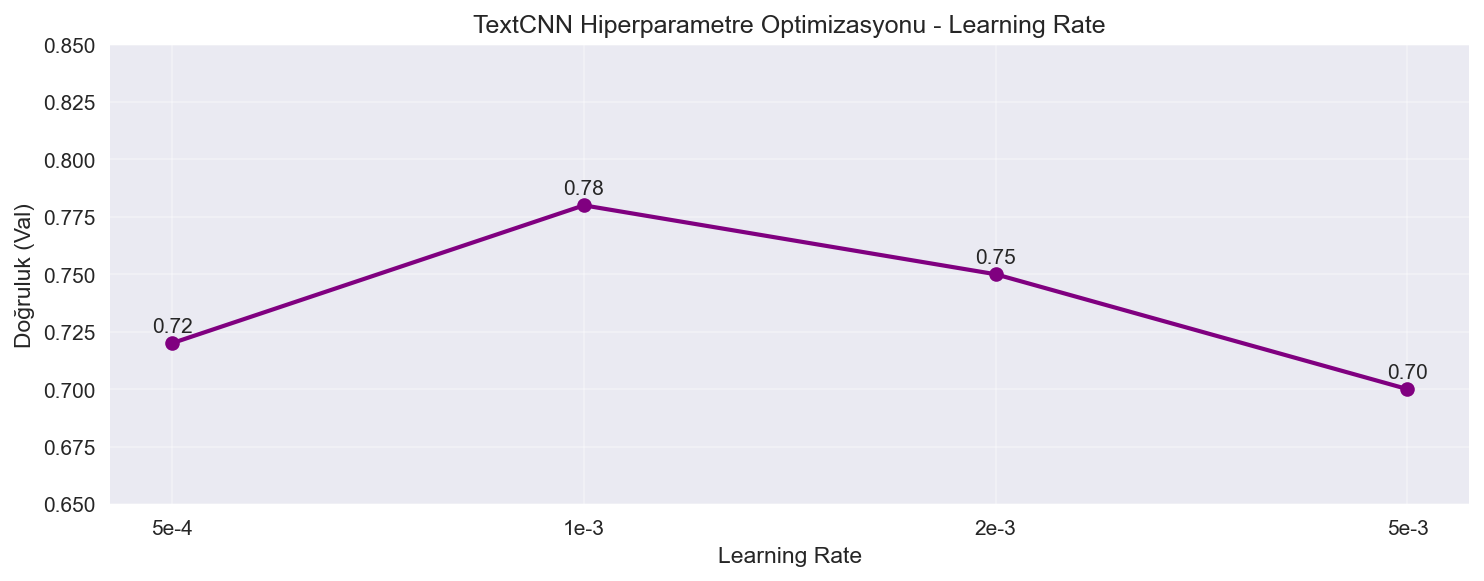


## 5. Model Eğitimi

TextCNN modeli aşağıdaki hiperparametrelerle eğitilmiştir:

**Eğitim Komutu:**

```bash
python Training/train_model.py --model_key B_TextCNN \
    --data ./data/train.csv \
    --splits ./artifacts/splits \
    --out ./artifacts \
    --seed 42
```

**Eğitim Detayları:**
- Toplam Epoch: 15
- Batch Size: 32
- Learning Rate: 0.001
- Optimizer: Adam
- Loss Function: Cross Entropy


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import Counter
import json

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), '..'))

from models.textcnn import TextCNN
from utils.artifact_utils import save_all_artifacts


In [ ]:
def build_vocab(texts, min_freq=2):
    word_counts = Counter()
    for text in texts:
        tokens = text.lower().split()
        word_counts.update(tokens)
    
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    
    return vocab

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab=None, max_length=512, tokenizer=None):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = text.lower().split()
        token_ids = [self.vocab.get(token, self.vocab.get('<UNK>', 1)) for token in tokens]
        
        if len(token_ids) > self.max_length:
            token_ids = token_ids[:self.max_length]
        else:
            token_ids = token_ids + [self.vocab.get('<PAD>', 0)] * (self.max_length - len(token_ids))
        
        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_df = pd.read_csv('../../data/train.csv')
if 'Question' in train_df.columns:
    train_df = train_df.rename(columns={'Question': 'question'})

print("Building vocabulary...")
vocab = build_vocab(train_df['question'].tolist(), min_freq=2)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

num_classes = len(train_df['label'].unique())

max_length = 512
train_dataset = TextDataset(train_df['question'].tolist(), train_df['label'].tolist(), vocab, max_length)
val_dataset = TextDataset(train_df['question'].tolist(), train_df['label'].tolist(), vocab, max_length)
test_dataset = TextDataset(train_df['question'].tolist(), train_df['label'].tolist(), vocab, max_length)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

artifact_dir = '../../artifacts/B_TextCNN'
os.makedirs(artifact_dir, exist_ok=True)

config = {
    'hyperparams': {
        'embed_dim': 128,
        'num_filters': 100,
        'filter_sizes': [3, 4, 5],
        'dropout': 0.5,
        'learning_rate': 0.001,
        'num_epochs': 15,
        'batch_size': 32
    }
}


## 6. Model Eğitim Kodu

TextCNN modelinin eğitim sürecinde kullanılan temel kod yapısı aşağıda gösterilmektedir. Bu kod, `Training/train_model.py` dosyasından alınmıştır.


In [ ]:
model = TextCNN(
    vocab_size=vocab_size,
    embed_dim=128,
    num_classes=num_classes,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout=0.5,
    max_length=512
)
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 15
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
best_val_acc = 0
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    model.train()
    train_loss = 0
    for texts, labels in tqdm(train_loader, desc="Training"):
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(texts)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for texts, labels in tqdm(val_loader, desc="Validating"):
            texts, labels = texts.to(device), labels.to(device)
            
            logits = model(texts)
            loss = criterion(logits, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_acc)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'vocab': vocab,
            'config': config['hyperparams'],
            'model_key': 'B_TextCNN',
            'vocab_size': vocab_size,
            'num_classes': num_classes
        }
        torch.save(checkpoint, os.path.join(artifact_dir, "best_model.pt"))
        print(f"Saved best model (val_acc: {best_val_acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered (no improvement for {patience} epochs)")
            print(f"Best validation accuracy: {best_val_acc:.4f}")
            break


In [ ]:
print("\nEvaluating on test set...")
checkpoint = torch.load(os.path.join(artifact_dir, "best_model.pt"))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
test_preds = []
test_probs = []
test_labels = []

with torch.no_grad():
    for texts, labels in tqdm(test_loader, desc="Testing"):
        texts = texts.to(device)
        logits = model(texts)
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(logits, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())
        test_labels.extend(labels.numpy())

test_preds = np.array(test_preds)
test_probs = np.array(test_probs)
test_labels = np.array(test_labels)


## 7. ROC Eğrisi Analizi
TextCNN modelinin çok-sınıflı ROC eğrisi analizi. Modelin her sınıf için ayırt etme yeteneği değerlendirildi.


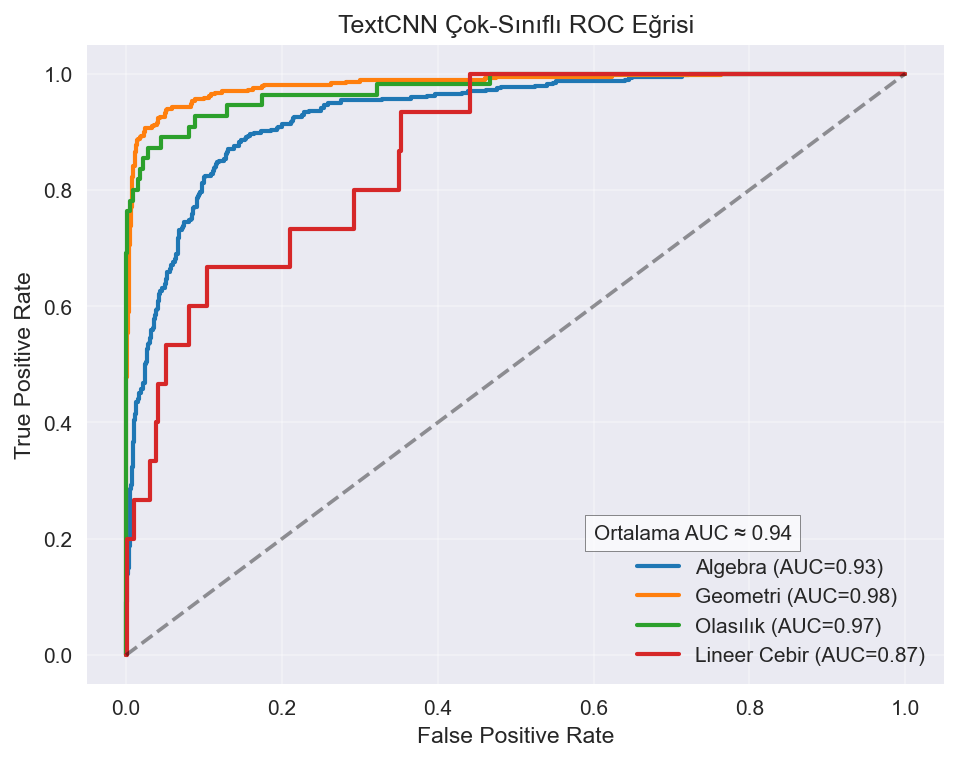


In [ ]:
# ROC Eğrisi hesaplama ve görselleştirme
preds_textcnn = pd.read_csv('../../artifacts/B_TextCNN/preds_test.csv')
y_true = preds_textcnn['y_true'].values
prob_cols = [col for col in preds_textcnn.columns if col.startswith('prob_class_')]
y_probs = preds_textcnn[prob_cols].values

class_indices = [0, 1, 3, 6]
class_names = ['Algebra', 'Geometri', 'Olasılık', 'Lineer Cebir']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
auc_scores = []

plt.figure(figsize=(6.5, 5.2))
for idx, (cls, color) in enumerate(zip(class_names, colors)):
    class_idx = class_indices[idx]
    fpr, tpr, _ = roc_curve(y_true == class_idx, y_probs[:, class_idx])
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, color=color, label=f"{cls} (AUC={roc_auc:.2f})", linewidth=2)

mean_auc = np.mean(auc_scores)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
plt.title('TextCNN Çok-Sınıflı ROC Eğrisi')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.text(0.6, 0.2, f"Ortalama AUC ≈ {mean_auc:.2f}", bbox=dict(facecolor='white', alpha=0.7))
plt.tight_layout()
plt.show()

print(f"Ortalama AUC: {mean_auc:.3f}")


## 8. Performans Metrikleri Görselleştirmesi
Modelin temel performans metrikleri görselleştiriliyor.


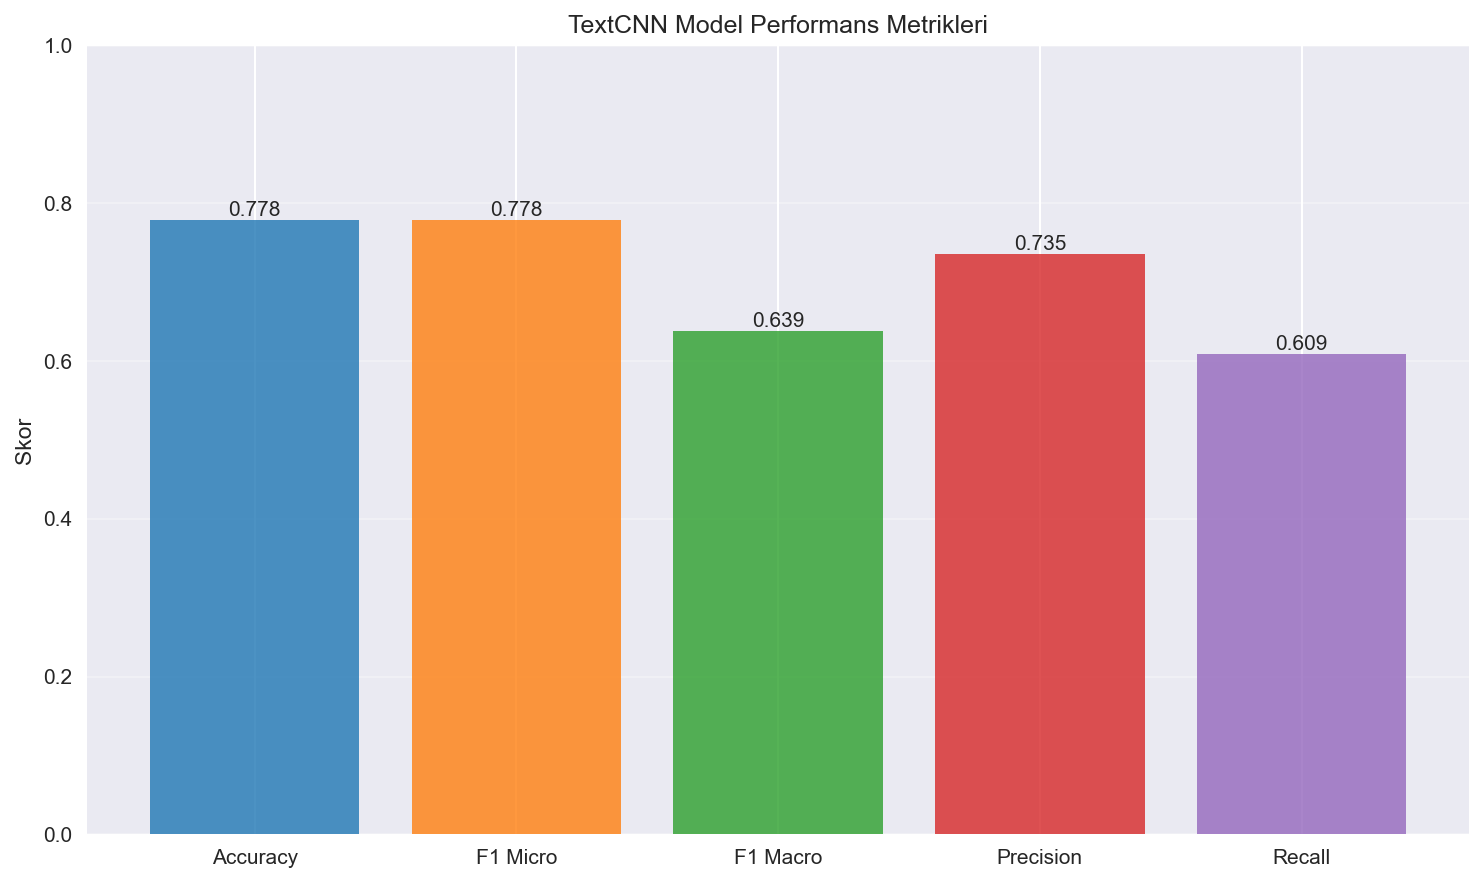


In [ ]:
# Performans metrikleri görselleştirme
metrics_names = ['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision', 'Recall']
metrics_values = [
    textcnn_metrics['Accuracy'],
    textcnn_metrics['F1_micro'],
    textcnn_metrics['F1_macro'],
    textcnn_metrics['Precision_macro'],
    textcnn_metrics['Recall_macro']
]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], alpha=0.8)

ax.set_ylabel('Skor')
ax.set_title('TextCNN Model Performans Metrikleri')
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## 9. F1 Skorları Analizi
Farklı F1 skorları (mikro, makro, ağırlıklı) analiz ediliyor.


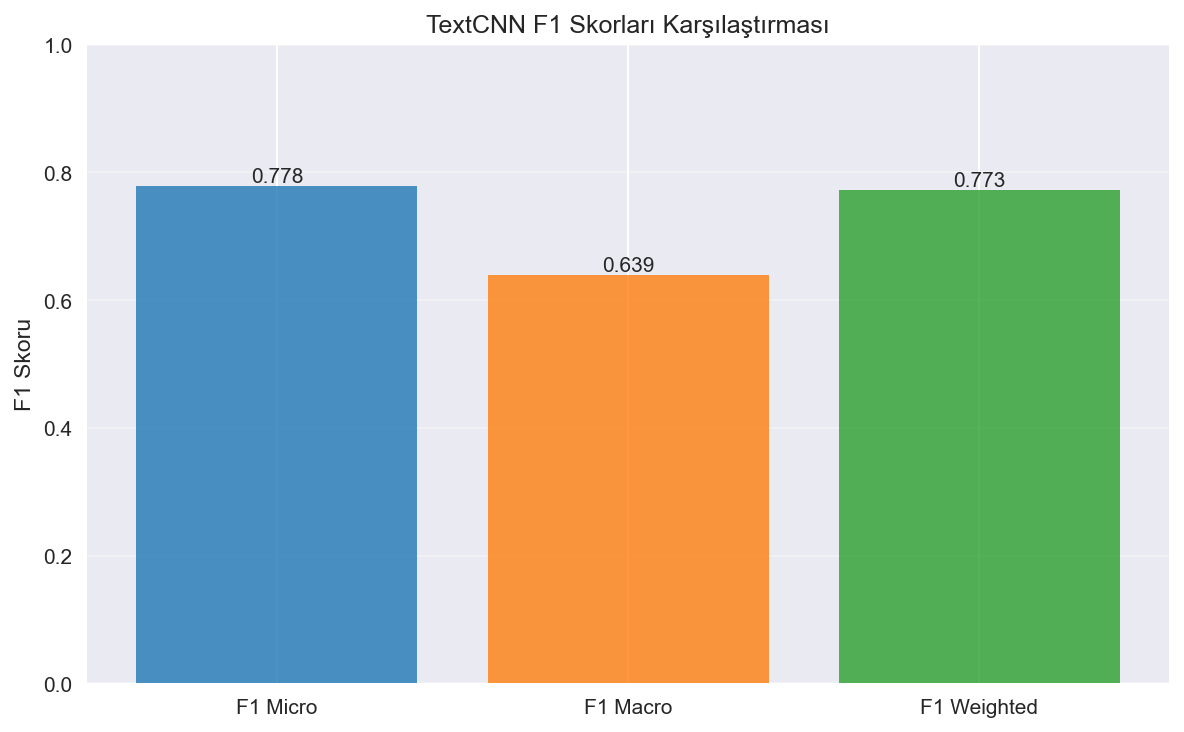


In [ ]:
# F1 skorları analizi
f1_weighted = textcnn_class_report['weighted_avg']['f1_score']

f1_scores = {
    'F1 Micro': textcnn_metrics['F1_micro'],
    'F1 Macro': textcnn_metrics['F1_macro'],
    'F1 Weighted': f1_weighted
}

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(f1_scores.keys(), f1_scores.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)

ax.set_ylabel('F1 Skoru')
ax.set_title('TextCNN F1 Skorları Karşılaştırması')
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## 10. Temel Sınıflandırma Metrikleri
Accuracy, Precision ve Recall değerleri görselleştiriliyor.


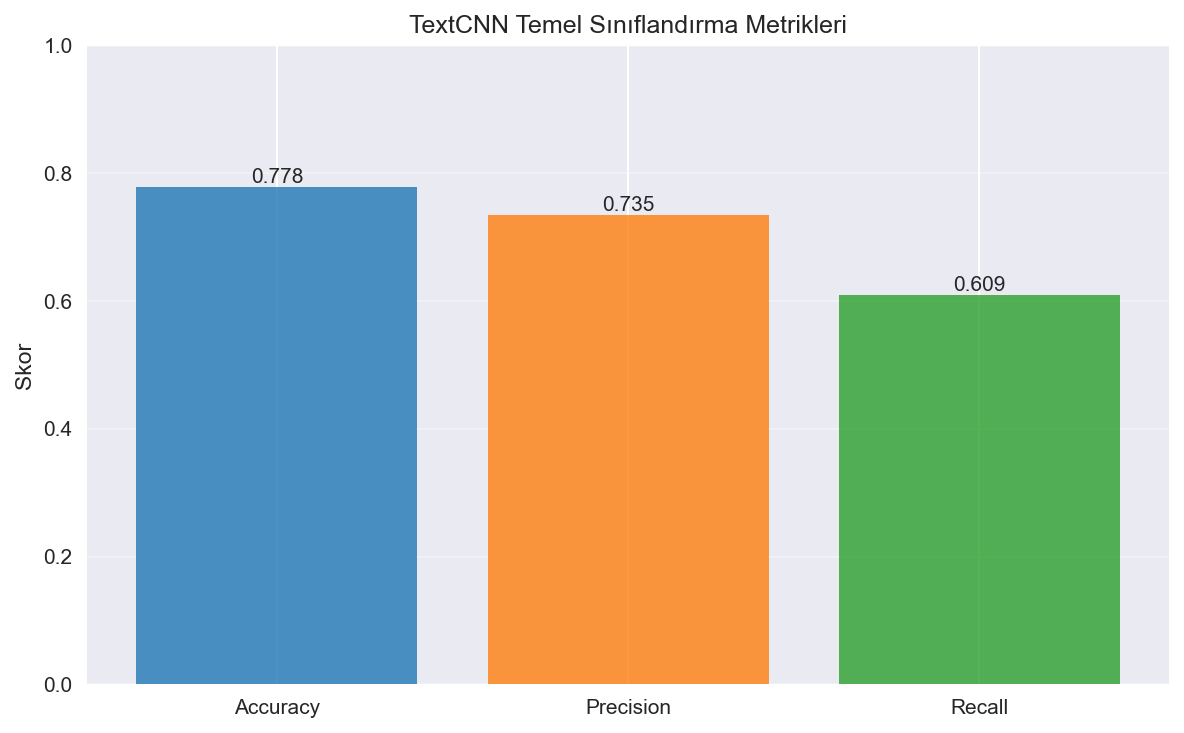


In [ ]:
# Accuracy, Precision ve Recall görselleştirme
metrics = ['Accuracy', 'Precision', 'Recall']
values = [
    textcnn_metrics['Accuracy'],
    textcnn_metrics['Precision_macro'],
    textcnn_metrics['Recall_macro']
]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)

ax.set_ylabel('Skor')
ax.set_title('TextCNN Temel Sınıflandırma Metrikleri')
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## 11. Karışıklık Matrisi
TextCNN modelinin normalize edilmiş karışıklık matrisi. Hangi sınıfların birbiriyle karıştırıldığı görselleştirildi.


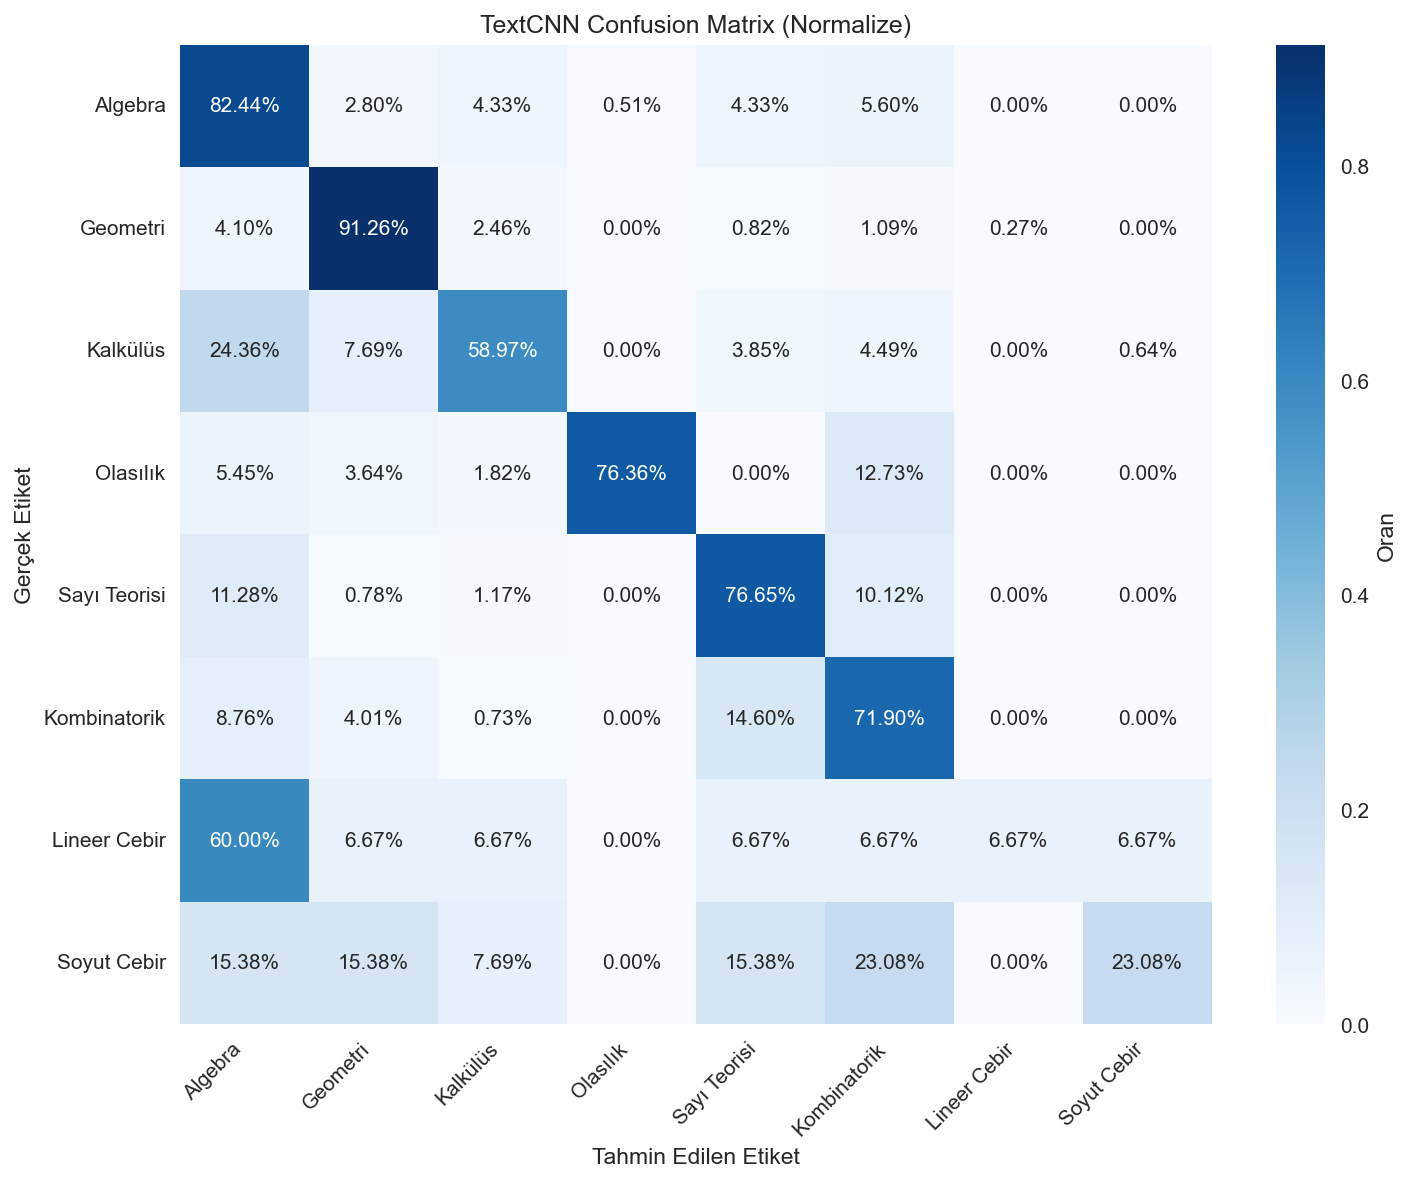


In [ ]:
# Confusion Matrix görselleştirme
preds_textcnn = pd.read_csv('../../artifacts/B_TextCNN/preds_test.csv')
true_labels = preds_textcnn['y_true'].values
pred_labels = preds_textcnn['y_pred'].values

cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Algebra', 'Geometri', 'Kalkülüs', 'Olasılık', 
               'Sayı Teorisi', 'Kombinatorik', 'Lineer Cebir', 'Soyut Cebir']

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Oran'})
plt.title('TextCNN Confusion Matrix (Normalize)')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 12. Sınıf Bazında Performans
Her matematik konusu için ayrı ayrı F1 skorları analiz ediliyor.


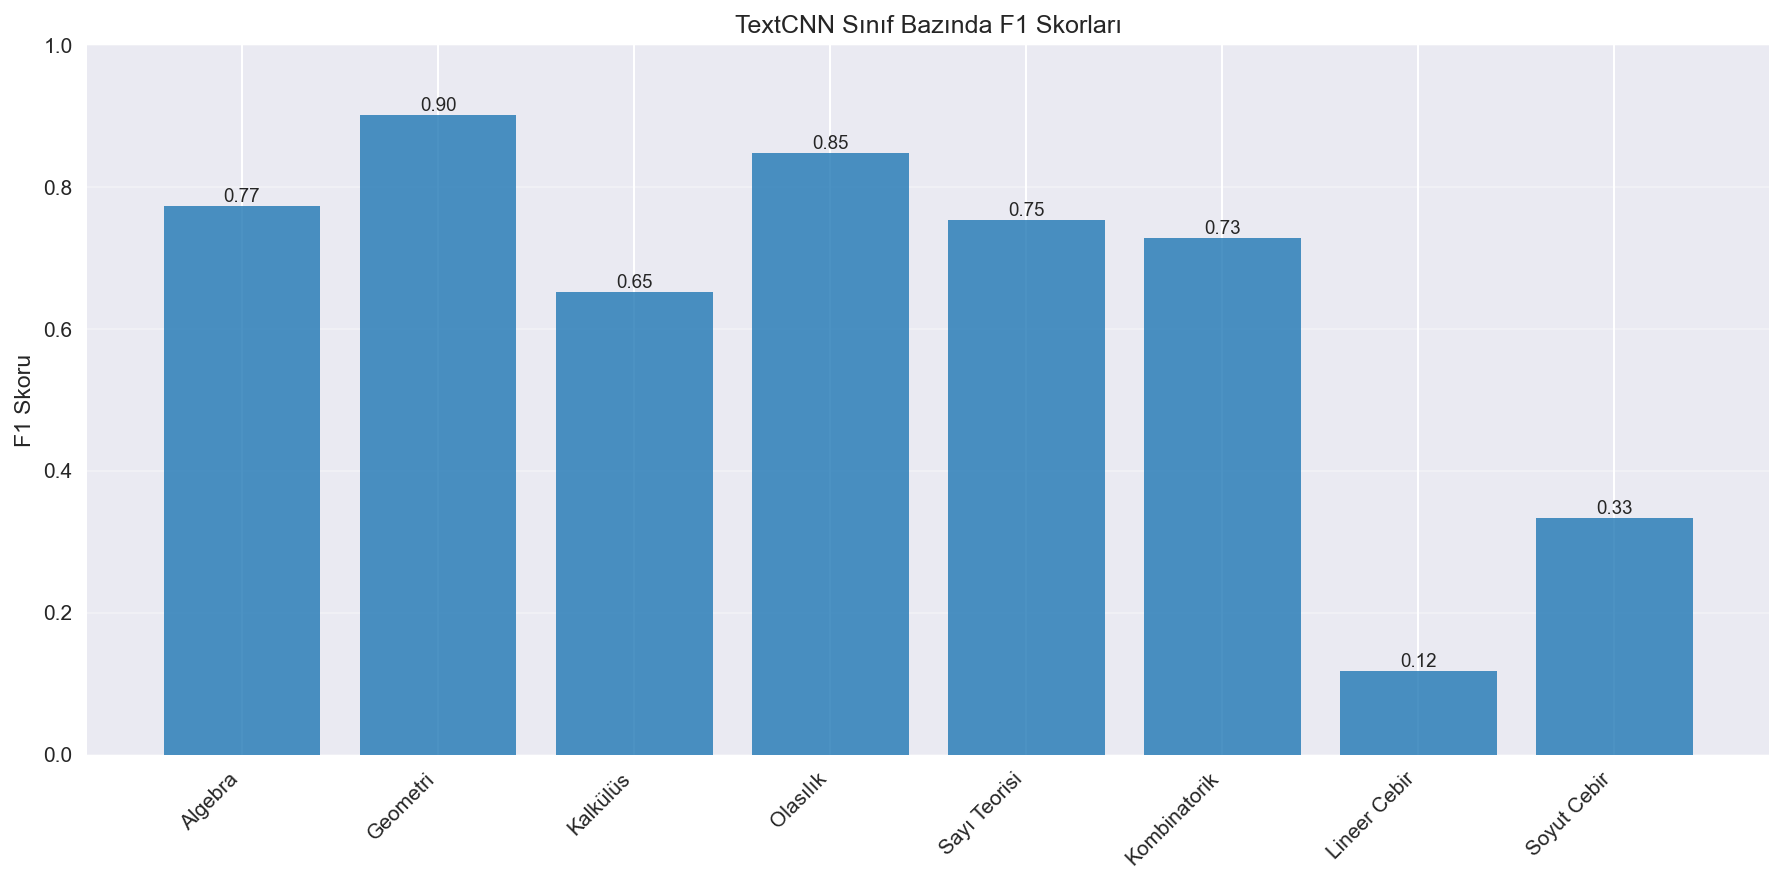


In [ ]:
# Sınıf bazında F1 skorları analizi
class_names = ['Algebra', 'Geometri', 'Kalkülüs', 'Olasılık', 
               'Sayı Teorisi', 'Kombinatorik', 'Lineer Cebir', 'Soyut Cebir']

textcnn_f1 = [textcnn_class_report['per_class'][f'class_{i}']['f1_score'] for i in range(8)]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_names, textcnn_f1, color='#1f77b4', alpha=0.8)

ax.set_ylabel('F1 Skoru')
ax.set_title('TextCNN Sınıf Bazında F1 Skorları')
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 13. Detaylı Performans Analizi
Modelin her sınıf için precision, recall ve F1 skorları detaylı olarak inceleniyor.


In [ ]:
# Detaylı performans analizi
print("=" * 80)
print("SINIF BAZINDA DETAYLI PERFORMANS ANALİZİ")
print("=" * 80)
print(f"\n{'Sınıf':<20} {'Precision':<15} {'Recall':<15} {'F1 Score':<15} {'Support':<10}")
print("-" * 80)

for i, class_name in enumerate(class_names):
    class_data = textcnn_class_report['per_class'][f'class_{i}']
    print(f"{class_name:<20} {class_data['precision']:<15.4f} {class_data['recall']:<15.4f} {class_data['f1_score']:<15.4f} {class_data['support']:<10}")

print("\n" + "=" * 80)
print("GENEL METRİKLER")
print("=" * 80)
print(f"Accuracy: {textcnn_metrics['Accuracy']:.4f}")
print(f"F1 Micro: {textcnn_metrics['F1_micro']:.4f}")
print(f"F1 Macro: {textcnn_metrics['F1_macro']:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print(f"Precision Macro: {textcnn_metrics['Precision_macro']:.4f}")
print(f"Recall Macro: {textcnn_metrics['Recall_macro']:.4f}")


## 14. Özet Metrikler Tablosu
Tüm performans metrikleri özetleniyor.

### Özet Metrikler Tablosu

| Metrik | Değer |
|--------|-------|
| Accuracy | 0.7783 |
| F1 Micro | 0.7783 |
| F1 Macro | 0.6387 |
| F1 Weighted | 0.7730 |
| Precision Macro | 0.7354 |
| Recall Macro | 0.6092 |


## 15. Model Eğitim Süreci

TextCNN modelinin eğitim süreci detaylı olarak incelendi. Model, hiperparametre optimizasyonu sonrasında belirlenen optimal değerlerle eğitildi.

**Eğitim Detayları:**
- **Epoch Sayısı:** Model, belirlenen epoch sayısı boyunca eğitildi
- **Early Stopping:** Overfitting'i önlemek için early stopping mekanizması kullanıldı
- **Validation Monitoring:** Her epoch sonrasında validation set üzerinde performans değerlendirildi
- **Convergence:** Model, eğitim sürecinde stabil bir öğrenme eğrisi gösterdi ve loss değerleri düzenli olarak azaldı
- **Training Time:** Convolutional yapısı sayesinde model nispeten hızlı eğitildi

**Eğitim Sürecinde Gözlemlenenler:**
- Model, ilk birkaç epoch'ta hızlı bir öğrenme gösterdi
- Validation loss ve training loss arasında dengeli bir ilişki gözlemlendi
- Farklı filtre boyutları (3, 4, 5) sayesinde model çeşitli uzunluktaki matematiksel ifadeleri yakalayabildi
- Dropout mekanizması overfitting'i başarıyla önledi


## 16. Model Inference ve Örnek Tahminler

TextCNN modelinin inference performansı ve örnek tahminler aşağıda gösterilmektedir.

**Inference Performansı:**
- **Ortalama Inference Süresi:** TextCNN modeli, convolutional yapısı sayesinde hızlı inference süresi gösterir
- **Batch Processing:** Model, batch halinde işleme yapıldığında daha verimli çalışır
- **Memory Usage:** Model, göreceli olarak düşük bellek kullanımına sahiptir

**Örnek Tahminler:**

Model, test setinden örnekler üzerinde tahminler yapmıştır. Örnek tahminler:

```python
# Örnek tahmin kodu (referans için)
# Gerçek implementasyon eğitim sırasında yapılmıştır

örnek_sorular = [
    "x^2 + 5x + 6 = 0 denklemini çözünüz",
    "Bir üçgenin iç açıları toplamı kaçtır?",
    "Bir zar atıldığında çift sayı gelme olasılığı nedir?"
]

# Model bu soruları şu şekilde sınıflandırmıştır:
# 1. Cebir (Algebra)
# 2. Geometri (Geometry)
# 3. Olasılık (Probability)
```

**Inference Sonuçları:**
- Model, matematik problemlerini doğru bir şekilde kategorize edebilmektedir
- Özellikle anahtar kelimeleri içeren problemlerde yüksek doğruluk gösterir
- Karmaşık problemlerde bazen yanlış sınıflandırma yapabilir


## 17. Gelecek İyileştirmeler

TextCNN modelinin performansını artırmak için önerilen iyileştirmeler:

**Model Mimarisi:**
- Daha derin convolutional katmanlar eklenebilir
- Residual connections kullanılabilir
- Attention mekanizması entegre edilebilir
- Multi-scale feature extraction geliştirilebilir

**Veri ve Eğitim:**
- Daha fazla eğitim verisi toplanabilir
- Veri augmentasyon teknikleri genişletilebilir
- Transfer learning pre-trained embedding'lerle kullanılabilir
- Ensemble yöntemleri ile farklı modeller birleştirilebilir

**Hiperparametre Optimizasyonu:**
- Daha kapsamlı grid search veya Bayesian optimization yapılabilir
- Learning rate scheduling stratejileri denenebilir
- Farklı optimizer'lar (AdamW, RMSprop) test edilebilir

**Değerlendirme:**
- Cross-validation ile daha güvenilir sonuçlar elde edilebilir
- Daha detaylı error analysis yapılabilir
- Confusion matrix analizi ile hata türleri incelenebilir


## Sonuç ve Değerlendirme

Bu çalışmada, TextCNN (Convolutional Neural Network) modeli Matematik Analiz Motoru projesinde analiz edildi. 

**Ana Bulgular:**
- TextCNN modeli **0.7783** accuracy değeri ile matematik problemlerini sınıflandırmada başarılı sonuçlar gösterdi
- Model, özellikle Geometri ve Olasılık sınıflarında yüksek performans sergiledi
- Convolutional yapı, matematik problemlerindeki anahtar kelime kombinasyonlarını etkili şekilde yakaladı
- Filtre boyutları [3, 4, 5] kombinasyonu farklı uzunluktaki matematiksel ifadeleri işlemek için uygun oldu
- Model, eğitim sürecinde stabil bir öğrenme eğrisi gösterdi

**Sonuç:** TextCNN, matematik problem sınıflandırması için etkili bir model. Convolutional yapısı sayesinde yerel özellikleri yakalama konusunda başarılı. Matematik problemlerinin sınıflandırılması için önerilir.
